## 加载模型


In [1]:
import os
import json
import time
import web
import numpy as np
from PIL import Image
from config import *
from apphelper.image import union_rbox,adjust_box_to_origin,base64_to_PIL
from application import trainTicket,idcard 
if yoloTextFlag =='keras' or AngleModelFlag=='tf' or ocrFlag=='keras':
    if GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
        import tensorflow as tf
        from keras import backend as K
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        config.gpu_options.per_process_gpu_memory_fraction = 0.3## GPU最大占用量
        config.gpu_options.allow_growth = True##GPU是否可动态增加
        K.set_session(tf.Session(config=config))
        K.get_session().run(tf.global_variables_initializer())
    
    else:
      ##CPU启动
      os.environ["CUDA_VISIBLE_DEVICES"] = ''

if yoloTextFlag=='opencv':
    scale,maxScale = IMGSIZE
    from text.opencv_dnn_detect import text_detect
elif yoloTextFlag=='darknet':
    scale,maxScale = IMGSIZE
    from text.darknet_detect import text_detect
elif yoloTextFlag=='keras':
    scale,maxScale = IMGSIZE[0],2048
    from text.keras_detect import  text_detect
else:
     print( "err,text engine in keras\opencv\darknet")
     
if DETECTANGLE:
    from text.opencv_dnn_detect import angle_detect
else:
    angle_detect = None

if ocr_redis:
    ##多任务并发识别
    from helper.redisbase import redisDataBase
    ocr = redisDataBase().put_values
else:   
    from crnn.keys import alphabetChinese,alphabetEnglish
    if ocrFlag=='keras':
        from crnn.network_keras import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelKerasLstm
            else:
                ocrModel = ocrModelKerasDense
        else:
            ocrModel = ocrModelKerasEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
            
    elif ocrFlag=='torch':
        from crnn.network_torch import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelTorchLstm
            else:
                ocrModel = ocrModelTorchDense
                
        else:
            ocrModel = ocrModelTorchEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
    elif ocrFlag=='opencv':
        from crnn.network_dnn import CRNN
        ocrModel = ocrModelOpencv
        alphabet = alphabetChinese
    else:
        print( "err,ocr engine in keras\opencv\darknet")
     
    nclass = len(alphabet)+1   
    if ocrFlag=='opencv':
        crnn = CRNN(alphabet=alphabet)
    else:
        crnn = CRNN( 32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet)
    if os.path.exists(ocrModel):
        crnn.load_weights(ocrModel)
    else:
        print("download model or tranform model with tools!")
        
    ocr = crnn.predict_job
    
   
from main import TextOcrModel

model =  TextOcrModel(ocr,text_detect,angle_detect)
from apphelper.image import xy_rotate_box,box_rotate,solve


In [2]:
import cv2
import numpy as np

ft2 = cv2.freetype.createFreeType2()
ft2.loadFontData("/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc", 0)

def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
#         print('line:\n', line)
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        blurred_tmp = cv2.GaussianBlur(tmp,(3,3), 17)
        mask = np.zeros((imgH, imgW, 3), dtype=np.uint8)
        cv2.rectangle(mask, (int(x1), int(y1)), (int(x3), int(y3)),
                      color=(255, 255, 255), thickness=-1)
        tmp = np.where(mask==np.array([255, 255, 255]), blurred_tmp, tmp)
        ft2.putText(tmp, line['text'], (int(x1 + w * 0.1), int(y1)), fontHeight=int(h*0.9), color=(255, 51, 51), thickness=-1,
                    line_type=cv2.LINE_4, bottomLeftOrigin=False)
        # cv2.putText(tmp, line['text'], (int(cx), int(cy - 0.1 * h)), cv2.FONT_HERSHEY_SIMPLEX, h / 30, (255, 0, 0), 1, cv2.LINE_AA)
        i+=1
    return Image.fromarray(tmp).convert('RGB')


def plot_rboxes(img,boxes,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0


    for box in boxes:

        x1,y1,x2,y2,x3,y3,x4,y4 = box
        
        
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

********************************************************************** 
DEBUG: len(boxes): 563 , scores: (563,) , boxes: (563, 4)
It take:0.45865368843078613s
T4109661

T---------------4------1---0-----------9-----------6-----------6----1--
[h2F一二7/7---.c44-444081-11089972338..9909999997.16656677777...6-6011]11
Ju3TF字T7TF0.-e王9A中a-..4l209908932831117-gggggg9g71千-5763333716王57477770
Ig97j一/「F7Sc:一干qq9g11c2I32868787王金7:28gHHH7777cc.0王0BBB6448,71千子G13l-3.

886451

8---------------88------------6------------4-----------5---1
9g9988gggg48...8-38888288.1166-6777777..844-4444444..55-5117
g928子BfB74金31--39ggg22g33g..85西国6国中中中国711王子q中中中中227116999数7-
3日E2华3F7228c:1123-B3gg8王48265子阳7国中国王王88c4国学学g子2王中王377466740]

456551

4----------------5------------6------------5-----------5---1
Ah1学国4中42i1.1-.559559777777166-6677778...55-5597777715595117
-d4国中中494141..529S9959995-1.85医国7国中中国国7219999979995-769-9数7-
2p29学国小294l22166S-37中中2595265日西7国中国王47115天S野775子小3F1.866700]

6577711

6----------------5---------

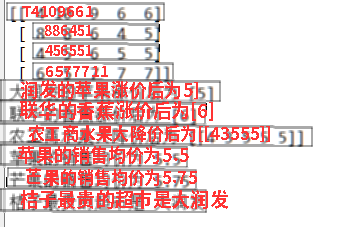

In [5]:
import time
from PIL import Image
p = './test/HW1.PNG'
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result,angle= model.model(img,
                                    detectAngle=False,##是否进行文字方向检测
                                    scale=scale,
                                    maxScale=maxScale,
                                    MAX_HORIZONTAL_GAP=80,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.7,
                                    TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                                     LINE_MIN_SCORE=0.1,                                             
                                    leftAdjustAlph=0,##对检测的文本行进行向左延伸
                                    rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
    print(line['raw res'])
plot_boxes(img,angle, result,color=(0,0,0))

In [ ]:
boxes,scores  = model.detect_box(img,608,2048)
plot_box(img,boxes)

In [3]:
"""Wrapper for various CTC decoders in SWIG."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import swig_decoders


class Scorer(swig_decoders.Scorer):
    """Wrapper for Scorer.
    :param alpha: Parameter associated with language model. Don't use
                  language model when alpha = 0.
    :type alpha: float
    :param beta: Parameter associated with word count. Don't use word
                 count when beta = 0.
    :type beta: float
    :model_path: Path to load language model.
    :type model_path: basestring
    """

    def __init__(self, alpha, beta, model_path, vocabulary):
        swig_decoders.Scorer.__init__(self, alpha, beta, model_path, vocabulary)


def ctc_greedy_decoder(probs_seq, vocabulary):
    """Wrapper for ctc best path decoder in swig.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :return: Decoding result string.
    :rtype: basestring
    """
    result = swig_decoders.ctc_greedy_decoder(probs_seq.tolist(), vocabulary)
    return result


def ctc_beam_search_decoder(probs_seq,
                            vocabulary,
                            beam_size,
                            cutoff_prob=1.0,
                            cutoff_top_n=40,
                            ext_scoring_func=None):
    """Wrapper for the CTC Beam Search Decoder.
    :param probs_seq: 2-D list of probability distributions over each time
                      step, with each element being a list of normalized
                      probabilities over vocabulary and blank.
    :type probs_seq: 2-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param cutoff_prob: Cutoff probability in pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_func: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    beam_results = swig_decoders.ctc_beam_search_decoder(
        probs_seq.tolist(), vocabulary, beam_size, cutoff_prob, cutoff_top_n,
        ext_scoring_func)
    beam_results = [(res[0], res[1]) for res in beam_results]
    return beam_results


def ctc_beam_search_decoder_batch(probs_split,
                                  vocabulary,
                                  beam_size,
                                  num_processes,
                                  cutoff_prob=1.0,
                                  cutoff_top_n=40,
                                  ext_scoring_func=None):
    """Wrapper for the batched CTC beam search decoder.
    :param probs_seq: 3-D list with each element as an instance of 2-D list
                      of probabilities used by ctc_beam_search_decoder().
    :type probs_seq: 3-D list
    :param vocabulary: Vocabulary list.
    :type vocabulary: list
    :param beam_size: Width for beam search.
    :type beam_size: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param cutoff_prob: Cutoff probability in vocabulary pruning,
                        default 1.0, no pruning.
    :type cutoff_prob: float
    :param cutoff_top_n: Cutoff number in pruning, only top cutoff_top_n
                         characters with highest probs in vocabulary will be
                         used in beam search, default 40.
    :type cutoff_top_n: int
    :param num_processes: Number of parallel processes.
    :type num_processes: int
    :param ext_scoring_func: External scoring function for
                             partially decoded sentence, e.g. word count
                             or language model.
    :type external_scoring_function: callable
    :return: List of tuples of log probability and sentence as decoding
             results, in descending order of the probability.
    :rtype: list
    """
    # probs_split = [probs_seq.tolist() for probs_seq in probs_split]
    probs_split = probs_split.tolist()

    batch_beam_results = swig_decoders.ctc_beam_search_decoder_batch(
        probs_split, vocabulary, beam_size, num_processes, cutoff_prob,
        cutoff_top_n, ext_scoring_func)
    batch_beam_results = [
        [(res[0], res[1]) for res in beam_results]
        for beam_results in batch_beam_results
    ]
    return batch_beam_results

In [4]:
alphabet_list = [c for c in alphabet]
scorer = Scorer(alpha=2.5, beta=0.3, model_path='./models/zh_giga.no_cna_cmn.prune01244.klm',
                vocabulary=alphabet_list)

In [ ]:
import time
from PIL import Image
from torch.nn.functional import softmax 

p = './test/HW1.PNG'
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result,angle= model.model(img,
                                    detectAngle=False,##是否进行文字方向检测
                                    scale=scale,
                                    maxScale=maxScale,
                                    MAX_HORIZONTAL_GAP=80,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.7,
                                    TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                                     LINE_MIN_SCORE=0.1,                                             
                                    leftAdjustAlph=0,##对检测的文本行进行向左延伸
                                    rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'], flush=True)
    print(line['raw res'], flush=True)
#     print(line['raw preds'].shape, flush=True)
#     print(line['raw preds'][:, :5, :].topk(k=4, dim=2))
#     print('pred labels:', line['raw preds'].max(2)[1].view(-1))
    beam_search_results = ctc_beam_search_decoder_batch(
            probs_split=softmax(line['raw preds'], dim=2),
            vocabulary=alphabet_list,
            beam_size=50,
            num_processes=1,
            ext_scoring_func=scorer,
            cutoff_prob=1.0,
            cutoff_top_n=50)
    print(beam_search_results[0][:4], flush=True)
plot_boxes(img,angle, result,color=(0,0,0))

********************************************************************** 
DEBUG: len(boxes): 563 , scores: (563,) , boxes: (563, 4)
It take:0.7295782566070557s
T4109661

T---------------4------1---0-----------9-----------6-----------6----1--
[h2F一二7/7---.c44-444081-11089972338..9909999997.16656677777...6-6011]11
Ju3TF字T7TF0.-e王9A中a-..4l209908932831117-gggggg9g71千-5763333716王57477770
Ig97j一/「F7Sc:一干qq9g11c2I32868787王金7:28gHHH7777cc.0王0BBB6448,71千子G13l-3.

